In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import sklearn.linear_model
import xgboost as xgb
from pytil.object import Namespace as O
from pytil.utility import *
from helpers import *
from pytil.quickvis import canvas

import random
ss = slice(None)
canvas(16, 2)

In [2]:
N_TRAIN, N_TEST = 623817, 640430
df = pd.read_csv('train.csv', index_col=0)
df.index = df.index - N_TRAIN
dg = pd.read_csv('test.csv', index_col=0)
dh = pd.concat([df, dg])
n_stock = len(set(dh.Stock))

# Explore

In [3]:
xfeats = 'x0 x1 x2 x3A x3B x3C x3D x3E x4 x5 x6'.split()
idfeats = 'Market Stock'.split()

In [ ]:
raise Exception("Don't go on blindly!")

## feature explore

In [ ]:
sortdh = dh.sort_values('Day')
res = [None] * n_stock
for idx, ((markt, stock), td) in enumerate(sortdh.groupby(['Market', 'Stock'])):
    data = [np.inf]
    for i in range(1, 200):
        roll = td.rolling(i, center=True, min_periods=1)
        est = (roll.y.sum() - td.y) / (roll.y.count() - 1)
        data.append((td.Weight * (est - td.y) ** 2).sum())
    res[stock] = min(range(len(data)), key=lambda x: data[x])
    if idx % 100 == 0:
        print(idx)

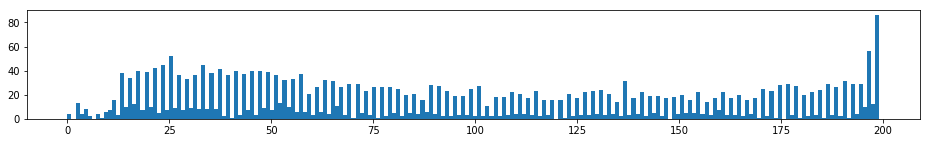

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-02-01 19:18:24.639794. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [542]:
plt.hist(res, bins=200);

In [ ]:
13, 25, 33, 57

## old things

In [724]:
agrp = np.abs(df).groupby('Market Stock'.split())
wycorr = agrp.corr().loc[(slice(None), slice(None), 'Weight',), ('y',)]

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:16.747078. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


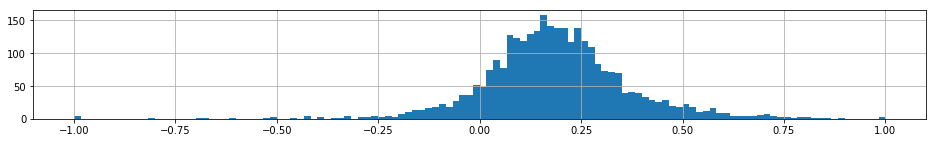

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:31.051520. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [725]:
res = agrp.corr().loc[(ss, ss, 'y'), 'x4']
res.hist(bins=120)

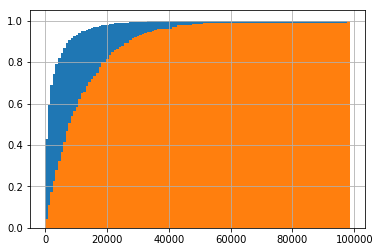

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 09:11:33.695777. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [341]:
hist(grp.sum().Weight, bins=120, normed=True, cumulative=True)
hist(grp.sum().Weight, weighted=True, bins=120, normed=True, cumulative=True)

In [394]:
listthing = [int(x[0]) for x in sorted(df[['Stock', col]].values, key=lambda x: x[1])[::-1][-1000:-500]]
thing = list(set(listthing))

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 10:21:28.672423. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


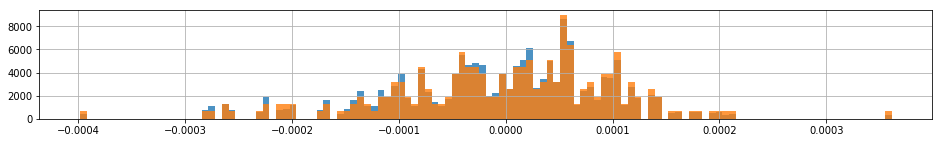

247 0.000397538089951


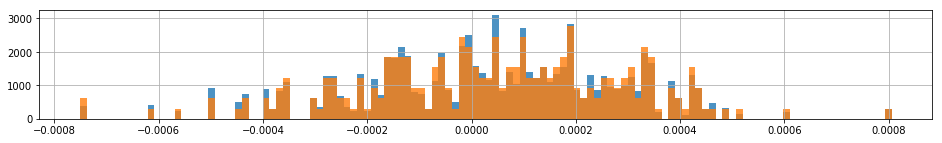

251 0.0867626267151


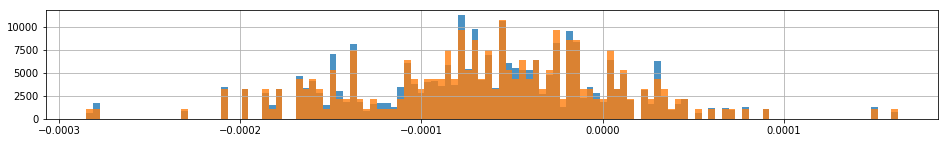

251 0.204674285411


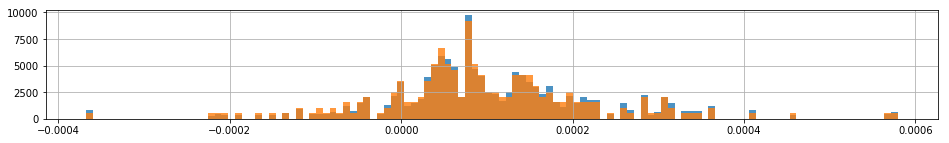

247 1.42622882884e-05


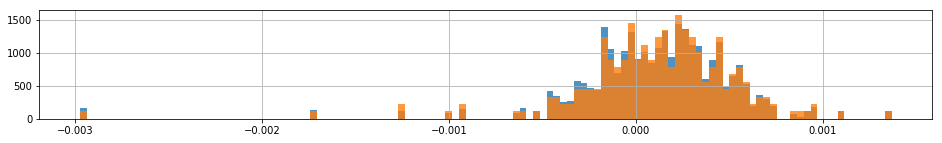

247 1.6676556502e-31


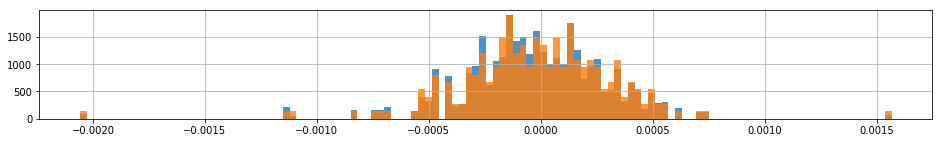

247 9.22979973834e-14


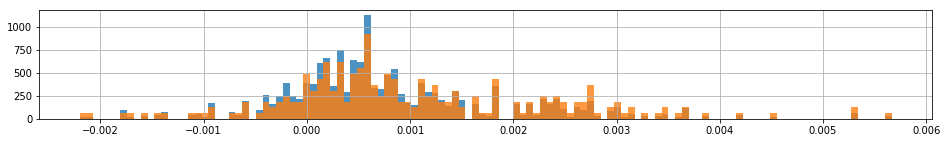

249 9.59286090927e-06


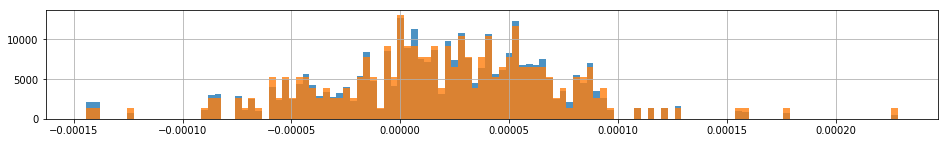

247 0.0197578412492


C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:25:03.178891. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [744]:
col = 'y'
from scipy import stats
ii = list(range(df.Stock.min(), df.Stock.max() + 1))
random.shuffle(ii)
ii = ii[:8]
#ii = thing
for i in range(len(ii)):
    q = df.query('Stock == ' + str(ii[i]))
    trans = q[col]
    trans.hist(bins=120, weights=q.Weight, normed=True, alpha=.8)
    trans.hist(bins=120, normed=True, alpha=.8)
    plt.show()
    print(len(trans), stats.normaltest(trans).pvalue)

## cv days selection

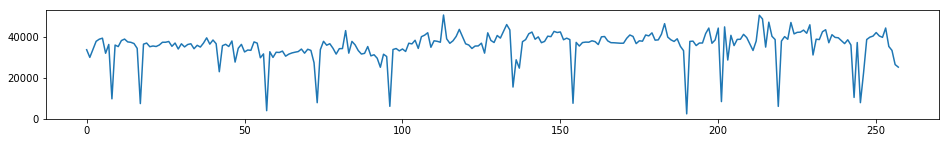

In [4]:
days = sorted(set(df.Day))
weights = [df.query('Day == ' + str(day)).Weight.sum() for day in days]
plt.plot(weights); plt.show()

# Simple model

In [4]:
# +2 to day to get 0 % 7 == Monday

In [4]:
market = pd.get_dummies(dh[['Market']], columns=['Market'])
stock = pd.get_dummies(dh[['Stock']], columns=['Stock'])
#day = pd.get_dummies(dh[['Day']], columns=['Day'])

In [5]:
dayseg = dh['Day']
off0 = (dayseg + 2) // 14
off0.name = 'Biweek0'
off1 = (dayseg + 2 + 7) // 14
off1.name = 'Biweek1'
dayseg = pd.concat([off0, off1], axis=1)

In [6]:
wkdfeats = 'Monday Tuesday Wednesday Thursday Friday'.split()
weekday = ((dh.Day + 2) % 7)
weekday = weekday.map({i: s for i, s in enumerate(wkdfeats)})
weekday = pd.get_dummies(weekday)
weekday = weekday[wkdfeats]

In [7]:
rank = 1 - dh.groupby(['Market', 'Stock']).transform(lambda x: x.rank(pct=True, method='max', ascending=False))
rank = rank[[c for c in rank.columns if c != 'Weight' and c != 'y' and c != 'Day']]
rank.columns = [c + ' rank' for c in rank.columns]

In [42]:
trfilt = dh.Day.isin(days_a)
#trfilt = dh.Day == dh.Day

In [43]:
# TODO below code inefficient due to the unoptimized y[trfilt]

In [44]:
def helper(y):
    thing = y + np.nan
    thing.loc[trfilt] = y[trfilt]
    return thing
ymean = dh.groupby(['Market', 'Stock']).y.transform(lambda y: helper(y).mean())
ymean = ymean.fillna(0)
ymean.name = 'y mean'

In [278]:
def get_rolling_average(x, window, *args, **kw):
    roll = x.rolling(window, min_periods=1, *args, **kw)
    est = (roll.sum() - x) / (roll.count() - 1)
    return est
def helper(y):
    thing = y + np.nan
    thing.loc[trfilt] = y[trfilt]
    return thing
timedh = dh.sort_values('Day')
timey = timedh.groupby(['Market', 'Stock']).y
yrolls = []
for w in range(5, 58, 4): #[13, 25, 33, 57]:
    roll = timey.transform(lambda y: get_rolling_average(helper(y), w, center=True))
    roll.name = 'y mean((' + str(w) + '))center'
    yrolls.append(roll)
    #roll = timey.transform(lambda y: get_rolling_average(y[::-1], w, center=False)[::-1])
    #roll.name = 'y mean((' + str(w) + '))after'
    #yrolls.append(roll)
    #roll = timey.transform(lambda y: get_rolling_average(y, w, center=False))
    #roll.name = 'y mean((' + str(w) + '))before'
    #yrolls.append(roll)

In [11]:
aa = list(range(5, 58, 4))
aa.index(13), aa.index(25), aa.index(33), aa.index(57)

(2, 5, 7, 13)

In [12]:
windowdh = pd.concat([dh[idfeats], weekday, dh[xfeats], rank], axis=1)
windowgrp = windowdh.groupby(idfeats)
shifts = []
plains = []
for i in [-1, 1]: # <-- the shifts
    shifted = windowgrp.shift(i)
    if i:
        shifted.columns = [x + ' (' + str(-i) + ')' for x in shifted.columns]
    shifts.append(shifted)

In [13]:
#stockparts = []
#for i in range(80):
#    randmap = list(range(n_stock))
#    random.shuffle(randmap)
#    stockpart = dh.Stock.map(lambda x: randmap[x])
#    stockpart.name = 'Stock ~' + str(i) + '~'
#    stockparts.append(stockpart)

In [14]:
# 

In [15]:
#
try:
    with open('days_order.txt', 'r') as file:
        days = [int(x) for x in file.read().splitlines()]
except FileNotFoundError:
    days = sorted(set(df.Day))
    random.shuffle(days)
    print('new days')
#
n_days = len(days)
#days_a, days_b, days_c = set(days[:n_days // 3]), set(days[n_days // 3:(2 * n_days) // 3]), set(days[(2 * n_days) // 3:])
days_a, days_b = set(days[:n_days // 2]), set(days[n_days // 2:])
#tr, cv, sc = df.Day.isin(days_a), df.Day.isin(days_b), df.Day.isin(days_c)
tr, cv = df.Day.isin(days_a), df.Day.isin(days_b)

In [45]:
#origdh = dh[['Market'] + xfeats]
#thedh = pd.concat([market, stock, weekday, origdh], axis=1)
thedh = pd.concat([dh[xfeats], market, dayseg, weekday, rank, ymean] + shifts, axis=1)

In [46]:
xdf = thedh.iloc[:N_TRAIN]
labels = list(xdf.columns)
n = len(df)
x = xdf.values
y = df.y.values #(df.y - ymean).values
y = 10000 * (y - ymean[:N_TRAIN].values)
weight = df.Weight.values

In [47]:
#n = len(df)
#a = list(range(n))
#random.shuffle(a)
#tr, cv = a[:n // 2], a[n // 2:]

In [48]:
dmat = O()
dmat.tr = xgb.DMatrix(x[tr], y[tr], feature_names=labels, weight=weight[tr])
dmat.cv = xgb.DMatrix(x[cv], y[cv], feature_names=labels, weight=weight[cv])
#dmat.sc = xgb.DMatrix(x[sc], y[sc], feature_names=labels, weight=weight[sc])
dmat.given = xgb.DMatrix(x, y, feature_names=labels, weight=weight)

In [49]:
model = None
boost_hp = dict(
    objective = 'reg:linear',
    booste = 'gbtree',
    max_depth = 9, #12,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    tree_method = 'hist',
    gamma = 0.00003,
    min_child_weight = 1000,
    eta = 0.1,
    seed = 0
)
cv_hp = dict(
    num_boost_round = 300,
    early_stopping_rounds = 30,
    nfold = 10,
    stratified = True,
    seed = 0
)
learn_hp = dict(
    num_boost_round = 500,
    early_stopping_rounds = 100,
    evals = [[dmat.tr, 'Train'], [dmat.cv, 'CV']]
)
model = xgb.train(boost_hp, dmat.tr, **learn_hp)

[0]	Train-rmse:2.98321	CV-rmse:2.95112
Multiple eval metrics have been passed: 'CV-rmse' will be used for early stopping.

Will train until CV-rmse hasn't improved in 100 rounds.
[1]	Train-rmse:2.93455	CV-rmse:2.90554
[2]	Train-rmse:2.89192	CV-rmse:2.86658
[3]	Train-rmse:2.85595	CV-rmse:2.83356
[4]	Train-rmse:2.82461	CV-rmse:2.80561
[5]	Train-rmse:2.79822	CV-rmse:2.78163
[6]	Train-rmse:2.77466	CV-rmse:2.7611
[7]	Train-rmse:2.75323	CV-rmse:2.74333
[8]	Train-rmse:2.73435	CV-rmse:2.72751
[9]	Train-rmse:2.71874	CV-rmse:2.71443
[10]	Train-rmse:2.70339	CV-rmse:2.70197
[11]	Train-rmse:2.68973	CV-rmse:2.69122
[12]	Train-rmse:2.67757	CV-rmse:2.68206
[13]	Train-rmse:2.66712	CV-rmse:2.67471
[14]	Train-rmse:2.65735	CV-rmse:2.66754
[15]	Train-rmse:2.64687	CV-rmse:2.66027
[16]	Train-rmse:2.638	CV-rmse:2.65407
[17]	Train-rmse:2.63086	CV-rmse:2.649
[18]	Train-rmse:2.62356	CV-rmse:2.64407
[19]	Train-rmse:2.61634	CV-rmse:2.63938
[20]	Train-rmse:2.61018	CV-rmse:2.63598
[21]	Train-rmse:2.60377	CV-rmse:2.6

[201]	Train-rmse:2.31653	CV-rmse:2.58047
[202]	Train-rmse:2.31578	CV-rmse:2.58056
[203]	Train-rmse:2.3146	CV-rmse:2.58066
[204]	Train-rmse:2.3136	CV-rmse:2.58076
[205]	Train-rmse:2.31282	CV-rmse:2.58086
[206]	Train-rmse:2.31197	CV-rmse:2.58098
[207]	Train-rmse:2.31108	CV-rmse:2.58088
[208]	Train-rmse:2.31043	CV-rmse:2.5808
[209]	Train-rmse:2.31012	CV-rmse:2.58081
[210]	Train-rmse:2.30944	CV-rmse:2.58091
[211]	Train-rmse:2.30884	CV-rmse:2.58091
[212]	Train-rmse:2.30806	CV-rmse:2.5808
[213]	Train-rmse:2.30667	CV-rmse:2.58058
[214]	Train-rmse:2.30567	CV-rmse:2.58056
[215]	Train-rmse:2.30448	CV-rmse:2.58072
[216]	Train-rmse:2.30352	CV-rmse:2.5809
[217]	Train-rmse:2.30259	CV-rmse:2.58109
[218]	Train-rmse:2.30171	CV-rmse:2.58109
[219]	Train-rmse:2.30087	CV-rmse:2.58118
[220]	Train-rmse:2.29994	CV-rmse:2.5812
[221]	Train-rmse:2.29929	CV-rmse:2.58131
[222]	Train-rmse:2.29821	CV-rmse:2.58162
[223]	Train-rmse:2.29741	CV-rmse:2.58176
[224]	Train-rmse:2.29708	CV-rmse:2.58171
[225]	Train-rmse:2.295

In [ ]:
[100]	Train-rmse:2.50238	CV-rmse:2.5416

In [ ]:
239685 256708 [370] depth9
237573 256405 [356] depth9 @withmeans
239055 256313 [314] depth9 @zeromeaned
236928 256113 [380] depth9 @zeromeaned @stocks

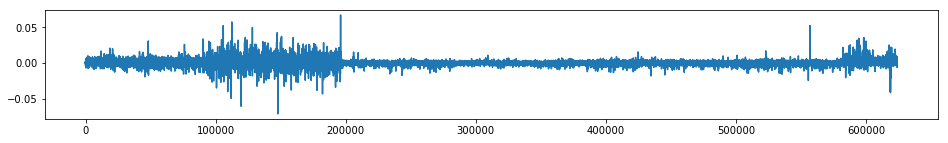

In [72]:
plt.plot(df.y.values);

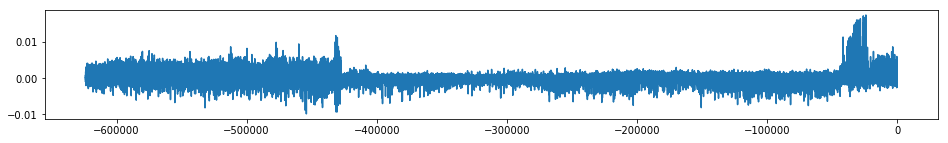

In [22]:
y_ = model.predict(dmat.given)
plt.plot(y_ / 10000 + ymean[:N_TRAIN]);

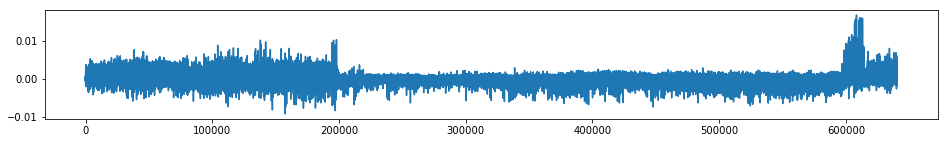

In [23]:
xtest = thedh.iloc[N_TRAIN:].values
dmat.test = xgb.DMatrix(xtest, feature_names=labels)
ytest_ = model.predict(dmat.test)
plt.plot((pd.Series(ytest_) / 10000 + ymean[N_TRAIN:]).rename('y'));

In [24]:
ypred = (pd.Series(ytest_) / 10000 + ymean[N_TRAIN:]).rename('y')
ypred.index.name = 'Index'
ypred.to_csv('model1.csv', header=True)
with open('days_order.txt', 'w') as file:
    print('\n'.join(str(x) for x in days), file=file)
omodel = model
odays = days

In [25]:
sorted(model.get_score().items(), key=lambda x: -x[1])

[('y mean', 761),
 ('x3D', 739),
 ('x4', 734),
 ('x3A', 632),
 ('x3E', 523),
 ('x3B', 483),
 ('x4 (1)', 467),
 ('x4 (-1)', 445),
 ('x3C', 444),
 ('x5', 438),
 ('x3E rank', 374),
 ('x3D rank', 350),
 ('x0 rank', 334),
 ('x3A rank', 315),
 ('x0', 288),
 ('x3B (1)', 269),
 ('x5 (1)', 232),
 ('x4 rank', 213),
 ('x3A (-1)', 212),
 ('x3A (1)', 209),
 ('x5 rank', 208),
 ('x5 (-1)', 198),
 ('x3B (-1)', 187),
 ('x3C (1)', 187),
 ('x0 (-1)', 184),
 ('x2', 183),
 ('x1', 176),
 ('x3E (-1)', 175),
 ('x3D (-1)', 150),
 ('x2 (1)', 143),
 ('x0 (1)', 139),
 ('x3E (1)', 129),
 ('x2 (-1)', 126),
 ('x3D (1)', 123),
 ('Biweek0', 122),
 ('x1 (-1)', 121),
 ('x3C (-1)', 114),
 ('x2 rank', 113),
 ('x6', 103),
 ('Market_1', 102),
 ('x6 rank', 102),
 ('x6 (-1)', 101),
 ('x0 rank (-1)', 94),
 ('Market_3', 93),
 ('x1 (1)', 89),
 ('x6 rank (-1)', 85),
 ('x5 rank (1)', 75),
 ('Biweek1', 74),
 ('x6 (1)', 72),
 ('x2 rank (-1)', 71),
 ('x1 rank', 71),
 ('x1 rank (-1)', 70),
 ('x6 rank (1)', 69),
 ('x5 rank (-1)', 67),


In [77]:
for i, tree in enumerate(model.get_dump()):
    print('<{}>'.format(i))
    print(tree)
    if i >= 10:
        break

<0>
0:leaf=-0.0999974

<1>
0:leaf=-0.0799979

<2>
0:leaf=-0.0639983

<3>
0:leaf=-0.0511987

<4>
0:[Market_1<-1e-06] yes=1,no=2,missing=1
	1:leaf=-0
	2:[Market_1<-1e-06] yes=3,no=4,missing=3
		3:leaf=-0
		4:[Market_1<-1e-06] yes=5,no=6,missing=5
			5:leaf=-0
			6:[Market_1<-1e-06] yes=7,no=8,missing=7
				7:leaf=-0
				8:[Market_1<-1e-06] yes=9,no=10,missing=9
					9:leaf=-0
					10:[Market_1<-1e-06] yes=11,no=12,missing=11
						11:leaf=-0
						12:[Market_1<-1e-06] yes=13,no=14,missing=13
							13:leaf=-0
							14:[Market_1<-1e-06] yes=15,no=16,missing=15
								15:leaf=-0
								16:[Market_1<-1e-06] yes=17,no=18,missing=17
									17:leaf=-0
									18:leaf=-0.0409589

<5>
0:[Market_1<-1e-06] yes=1,no=2,missing=1
	1:leaf=-0
	2:[Market_1<-1e-06] yes=3,no=4,missing=3
		3:leaf=-0
		4:[Market_1<-1e-06] yes=5,no=6,missing=5
			5:leaf=-0
			6:[Market_1<-1e-06] yes=7,no=8,missing=7
				7:leaf=-0
				8:[Market_1<-1e-06] yes=9,no=10,missing=9
					9:leaf=-0
					10:[Market_1<-1e-06] yes

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-31 22:32:44.135640. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## predict y-rank

# Split model

# Abs model